In [1]:
import sys
sys.path.append("/home/anonymous/ECAP/nyx/")

In [47]:
import astropy
import numpy as np
import jax
import jax.numpy as jnp
from astropy.coordinates import SkyCoord, Angle, EarthLocation
import astropy.units as u
from nsb2.instrument import HESS

from nyx.core.integrator import render
from nyx.core import Observation
from nyx.core.model import Model
from nyx.atmosphere import atmospheres
from nyx.instrument import instruments
from nyx.emitter import zodiacal, airglow, moon, stars

# How to use mcmc to fit parameters:

## Building model:

In [104]:
lam = np.linspace(300,700)

In [106]:
f = lambda lam, h, aod, ang: aod*(lam/500)**(-ang) * jnp.exp(-h/1.54)

In [12]:
# Instrument:
hess1 = HESS.CT1()
grid = np.stack([np.vstack(pix.centers) for pix in hess1.pixels])
values = np.stack([pix.values for pix in hess1.pixels])

HESS1 = instruments.EffectiveApertureInstrument(hess1.bandpass, grid, values)

# Atmosphere:
atmo = atmospheres.SingleScatteringAtmosphere(
        tau_rayleigh_func=lambda lam, h: 0.00878*(lam/1000)**-4.09 * jnp.exp(-h/8),
        tau_mie_func=lambda lam, h, aod, ang: aod*(lam/500)**(-ang) * jnp.exp(-h/1.54),
        hg_asymmetry=0.75
        )

# Emitters:
leinert = zodiacal.Leinert1998()
glow = airglow.ESOSkyCalc()
jones = moon.Jones2013()
gaia = stars.GaiaDR3(lim_mag=12)

# Combine to model:
pipeline = Model(HESS1, atmo, [glow, leinert, gaia, jones])

/usr/local/lib/python3.13/site-packages/astropy/units/quantity.py:1865: RuntimeWarning: All-NaN slice encountered
  result = super().__array_function__(function, types, args, kwargs)


## Load data:

In [13]:
from astropy.coordinates import AltAz
def frame_from_data(row, offsets=(0,0)):
    location = EarthLocation.from_geodetic(16.50097, -23.271514, 1800.)

    file = '/home/anonymous/ECAP/nyx/examples/nsb_CT1_{}_0.npy'.format(row.Run)
    df = pd.DataFrame.from_records(np.load(file))
    pivoted = df.pivot(columns='Pixel', index='Time', values='NSB').reindex(columns=np.arange(0, 960))
    pivoted.index = pivoted.index.astype(str).str.replace("UTC: ", "")
    pivoted = pivoted.reset_index()

    observations = []
    for i, data in pivoted.iterrows():
        obstime  = astropy.time.Time(data['Time'].replace(" ", 'T'), format='isot', scale='utc')
        altaz  = AltAz(obstime=obstime, location=location)
        
        ra, dec = row['Target_RA'] + row['Offset_x'] + offsets[0], row['Target_Dec'] + row['Offset_y']+offsets[1]
        target = SkyCoord(ra=ra, dec=dec, frame="icrs", unit="deg").transform_to(altaz)
        
        observations.append(Observation(location, obstime, target, -0.25*u.deg, fov=Angle(3*u.deg)))

    return observations, pivoted


def hap2cta(series, telId):
    if telId == 5:
        None
    else:
        reassign = pd.read_csv('/home/anonymous/ECAP/nyx/examples/ct1_pixel_assignment.txt', sep=' ', names=['old', 'new'], dtype=np.int32)
    
    re_dict = reassign.to_dict()['new']
    return series.rename(re_dict).reindex(np.arange(0,960)).fillna(np.nan).values


all_results = np.load('/home/anonymous/ECAP/nyx/ff_corr.npy')
def correct(run, img):
    if run < 163380:
        corr = all_results[0]
    elif run > 166200:
        corr = all_results[2]
    else:
        corr = all_results[1]
    return (img-corr[:,1])/corr[:,0]

import pandas as pd
df = pd.read_csv('/home/anonymous/ECAP/nyx/RunInformation.csv')
m_df = df[df['RunType'] == 'MoonlightObservationRun']

obs_id = 35

row = m_df.loc[14105]
observations, pivoted = frame_from_data(row)

obs = observations[obs_id]
run_img = correct(row.Run, hap2cta(pivoted.iloc[obs_id][1:],1))

/tmp/ipykernel_583683/1099476257.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return series.rename(re_dict).reindex(np.arange(0,960)).fillna(np.nan).values


## Initializing scene and defining loss function:

In [15]:
scene = pipeline.query(obs)
initial_params = scene.get_initial_parameters()

In [16]:
scene.print_parameters(format='table')

┌───────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Component  │ Type       │ Parameter    │ Shape │ Initial  │ Current │ Bounds │ Description            │ 
├───────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ atmosphere │ atmosphere │ aod_500      │ (1,)  │ 0.1000   │ -       │ -      │ AOD at 500nm           │ 
│ atmosphere │ atmosphere │ angstrom_exp │ (1,)  │ 1.0000   │ -       │ -      │ Angstrom exponent      │ 
│ atmosphere │ atmosphere │ hg_asymmetry │ (1,)  │ 0.7500   │ -       │ (0, 1) │ HG asymmetry           │ 
│ instrument │ instrument │ shift        │ (2,)  │ -        │ -       │ -      │ Pixel shift in rad     │ 
│ emitter_0  │ diffuse    │ sfu          │ (1,)  │ 100.0000 │ -       │ -      │ Solar flux value [SFU] │ 
└───────────────────────────────────────────────────────────────────────────────────────────────────────┘

Total parameters: 6


In [99]:
# Define loss function that takes shift as input
valid_mask = ~jnp.isnan(run_img)
n_valid = jnp.sum(valid_mask)

arcs = 1/3600/180*jnp.pi

@jax.jit
def loss_fn(eff, params):  
    scene_instance = scene.realize(params)
    pred = render(scene_instance) / 1e6
    
    run_img_safe = jnp.where(valid_mask, run_img, 0.0)
    pred_safe = jnp.where(valid_mask, pred, 0.0)
    likelihood = (eff*pred_safe - run_img_safe) / (0.1*run_img_safe + 1e-11)
    return likelihood * valid_mask

def residual(p):
    v = p.valuesdict()
    params = jnp.array((v['aod'],v['angstrom'], v['hg_asym'], v['xshift']*arcs, v['yshift']*arcs, v['sfu']))
    return loss_fn(jnp.array(v['eff']),params)

In [120]:
import lmfit
p = lmfit.Parameters()
p.add_many(
    ('eff', 0.8, True, 0.1, 1), 
    ('aod', 0.1, True, 0.01, 2.0), 
    ('angstrom', 1.2, True, 0.0, 10.0), 
    ('hg_asym', 0.85, True, 0.5, 1.0),
    ('xshift', 0.0, True, -400, 400), 
    ('yshift', 0.0, True, -400, 400), 
    ('sfu', 100, True, 60, 180)
)

In [121]:
res = lmfit.minimize(residual, p, nan_policy='omit')

In [124]:
emcee_params = res.params.copy()

nwalkers = 30
pos = [np.array(list(emcee_params.valuesdict().values())) * (1+1e-2*np.random.randn(len(p))) 
       for i in range(nwalkers)]


res = lmfit.minimize(residual, emcee_params, pos=pos, method='emcee', nan_policy='omit', burn=100, steps=1000,
                     thin=20, nwalkers=nwalkers, is_weighted=True, progress=True)

100%|██████████████████████████████████████████| 1000/1000 [02:42<00:00,  6.16it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [120.6894853   84.2976874  122.73114482  70.40803011 104.20614563
 114.99587209  74.9284626 ]


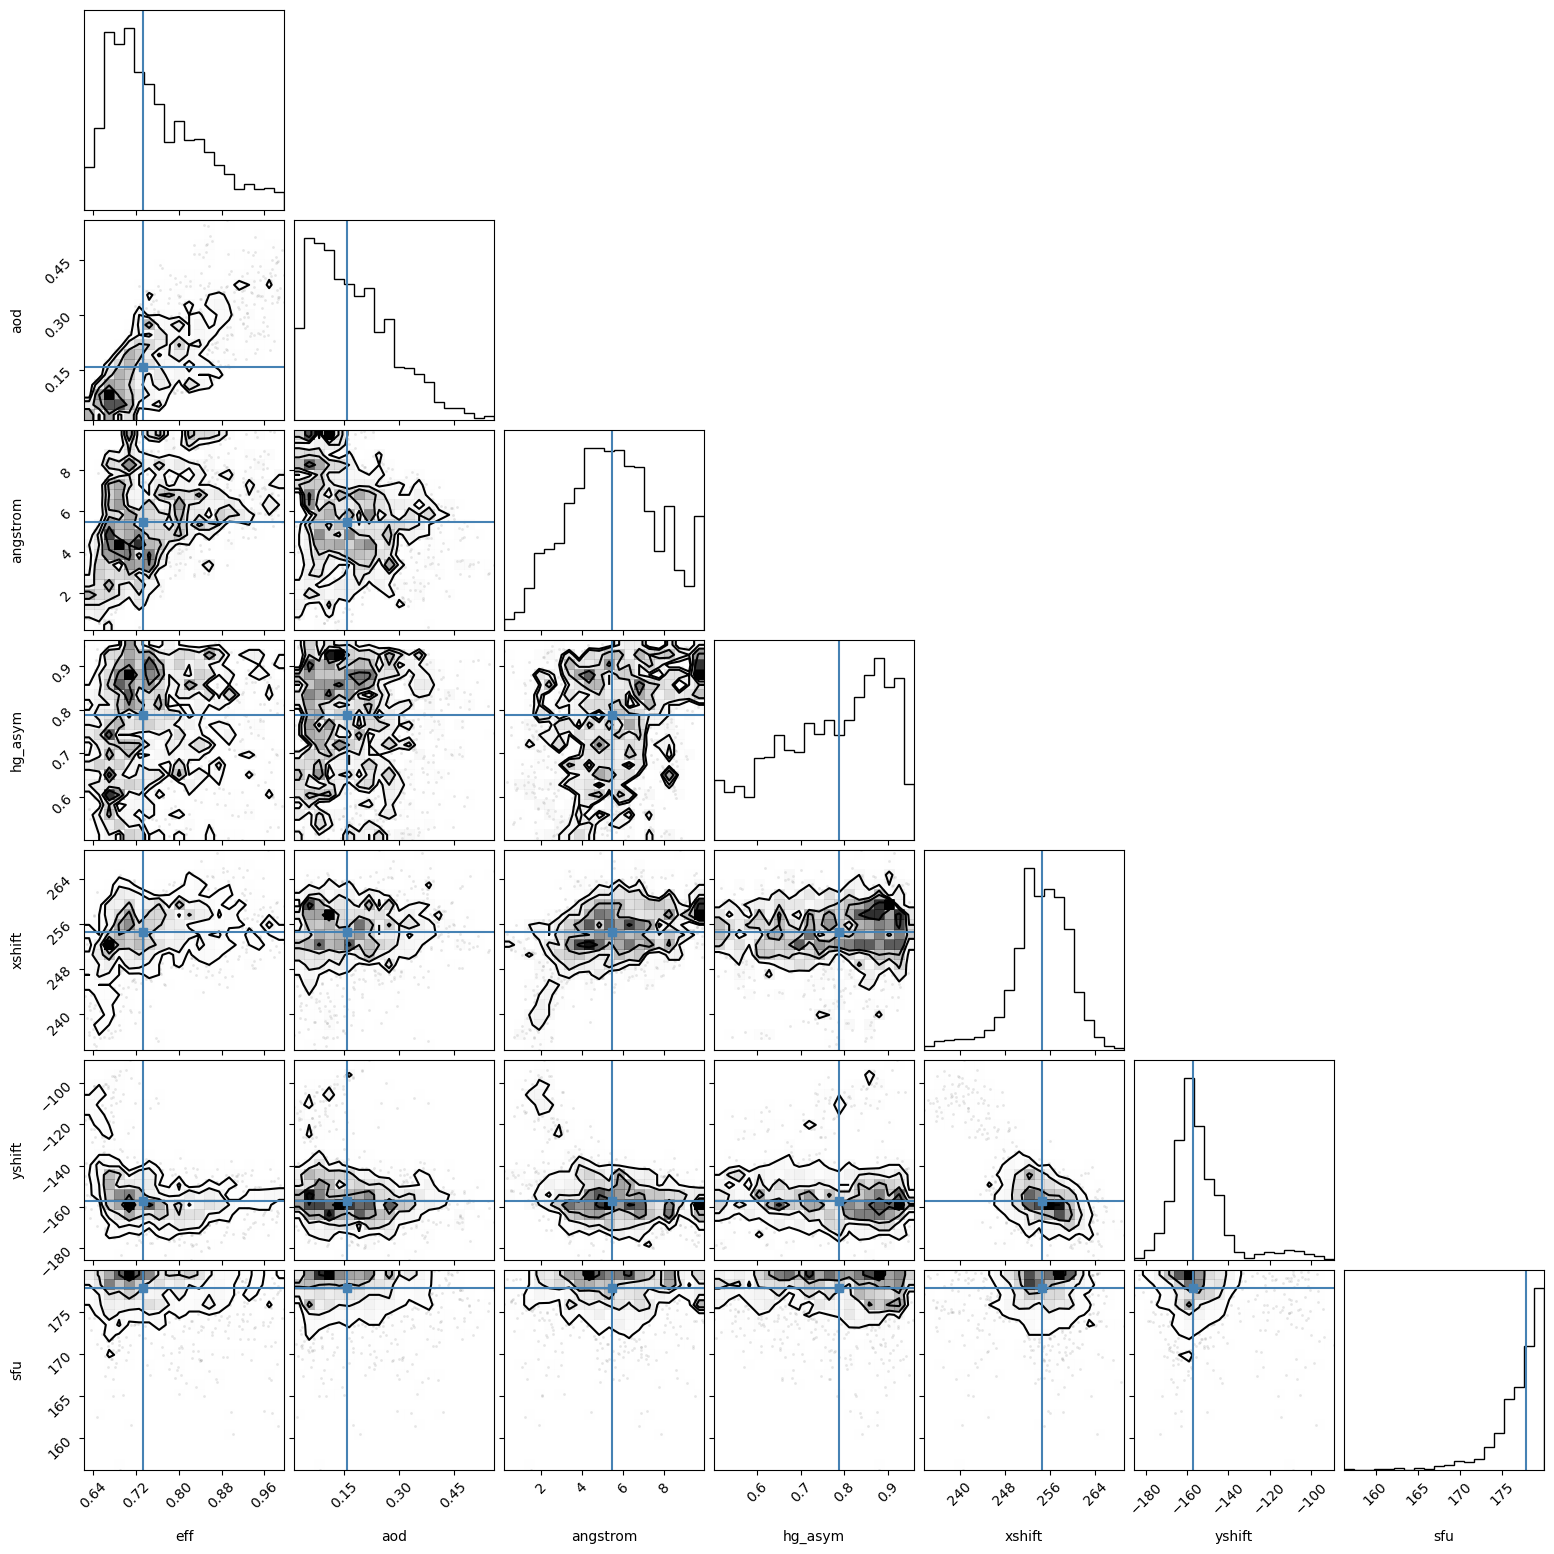

In [126]:
import corner

emcee_plot = corner.corner(res.flatchain, labels=res.var_names,
                           truths=list(res.params.valuesdict().values()))